In [15]:
import pandas as pd
import numpy as np
import sys
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [16]:
df_calls = pd.read_csv('../cotton/data/df_cotton_calls.csv')
df_prices = pd.read_csv('../cotton/data/df_cotton_prices.csv').rename(columns={'a_index':'price'})

<Axes: xlabel='date'>

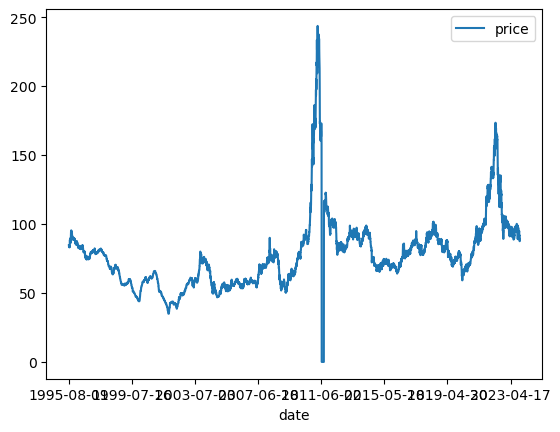

In [17]:
df_prices.plot(x='date', y='price')

In [18]:
# Overwrite prices from 30 days prior to the date at which there is an error in the data, up till the end of the problem.
# Need to overwrite with np.nan rather than dropping the rows so that the time integrigty of the outcome variables during 
# these is maintained. Otherwise prices from beyond the period will be brought forward into the outcomes prior to the period
df_prices['price'] = np.where((df_prices.date < '2011-05-10') | (df_prices.date > '2011-07-29'), df_prices['price'], np.nan)

<Axes: xlabel='date'>

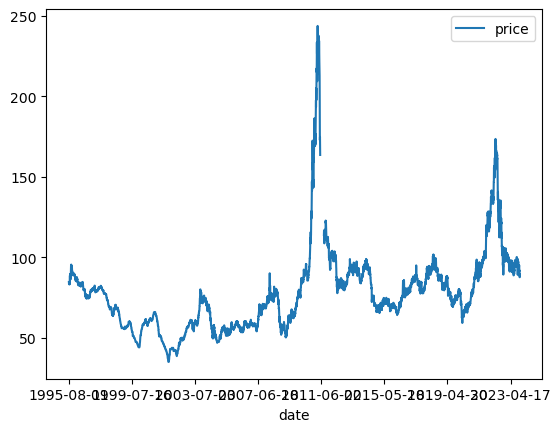

In [19]:
df_prices.plot(x='date', y='price')

In [59]:
var = 'unfixed_sale'

In [60]:
df_calls['unfixed_net'] = df_calls['unfixed_purchase'] - df_calls['unfixed_sale']
df_calls['report_month'] = pd.to_datetime(df_calls['date']).dt.month
df_calls['report_year'] = pd.to_datetime(df_calls['date']).dt.isocalendar().year
df_calls['futures_datetime'] = pd.to_datetime(df_calls['month'])
df_calls['futures_month'] = pd.to_datetime(df_calls['month']).dt.month
df_calls['futures_year'] = pd.to_datetime(df_calls['month']).dt.isocalendar().year

df_calls['futures_month_ranked'] = df_calls.groupby('date')['futures_datetime'].rank(method='dense')

df_calls['season'] = np.where(df_calls['report_year'] == df_calls['futures_year'], 'season1',
                       np.where(df_calls['report_year'] + 1 == df_calls['futures_year'], 'season2',
                          np.where(df_calls['report_year'] + 2 == df_calls['futures_year'], 'season3', 'season_OTHER')))
                          
df_calls['futures_month'] = np.where(df_calls['futures_month'] < 10, 
                                     '0' + df_calls['futures_month'].astype(str), 
                                     df_calls['futures_month'].astype(str))
df_calls['futures_reference'] = df_calls['season'] + '_' + df_calls['futures_month']

df_calls = df_calls[df_calls.season.isin(['season1', 'season2'])]

In [61]:
def build_outcomes(df_in, var, datetime_var, n_forward_looks = [1, 2, 3, 5, 10]):

    df = df_in.copy()
    for n in n_forward_looks:
        df[f'max_{n}_forward'] = (df.iloc[::-1]
                .rolling(n, on=datetime_var, min_periods=0)[var]
                .max()
                .iloc[::-1])
        
        df[f'mean_{n}_forward'] = (df.iloc[::-1]
                .rolling(n, on=datetime_var, min_periods=0)[var]
                .mean()
                .iloc[::-1])
        
        df[f'value_delta_mean_{n}_forward'] = df[f'mean_{n}_forward'] - df[var]
        df[f'value_delta_max_{n}_forward'] = df[f'max_{n}_forward'] - df[var]
        
        df[f'pct_delta_mean_{n}_forward'] = (df[f'mean_{n}_forward'] / df[var]) - 1
        df[f'pct_delta_max_{n}_forward'] = (df[f'max_{n}_forward'] / df[var]) - 1   
        
        df[f'mean_rise_{n}_forward'] = np.where(df[f'pct_delta_mean_{n}_forward'] > 0, 1, 0)
        df[f'max_rise_{n}_forward'] = np.where(df[f'pct_delta_max_{n}_forward'] > 0, 1, 0)
        
        # These values are highly correlated with calls variables, because they are higly correlted with the price at the given time.
        # The high correlation, along with price itself, only tells us that there are many unfixed purchases when prices are low and
        # fewer when prices are high. If we were to use the on-call variables which correlate highly with these, we would just be learning 
        # that when there are high unfixed calls, the price is likely to be low, rather than learning whther the price is likely to
        # increase from here
        df = df.drop(columns=[f'max_{n}_forward', f'mean_{n}_forward'])

    return df

def add_column_cyclical_features(df, datetime_var, period, start_num=0):
    
    values = 2 * np.pi * (df[datetime_var] - start_num) / period
    kwargs = {f'sin_{datetime_var}': lambda x: np.sin(values),
              f'cos_{datetime_var}': lambda x: np.cos(values)}
    
    return df.assign(**kwargs)

In [62]:
var

'unfixed_sale'

In [63]:
df_calls_pivot = df_calls.pivot_table(index='date', columns='futures_reference', 
                                      values=var, aggfunc='first')\
                         .reset_index()
df_weekly_averages = df_calls.pivot_table(index='report_week', columns='futures_reference', 
                                          values=var, aggfunc='mean')\
                             .reset_index()
df_weekly_averages = df_weekly_averages.rename(columns={x:'report_week_mean_'+x for x in df_weekly_averages.columns if 'season' in x})

df_yearweek_total_calls = df_calls.groupby(['date', 'report_year', 'report_week'])[var].sum()\
                                  .reset_index().rename(columns={var:'report_week_total_calls'})
df_weekly_total_calls_averages = df_yearweek_total_calls.groupby('report_week').report_week_total_calls.mean()\
                                                        .reset_index().rename(columns={'report_week_total_calls':'report_week_mean_total_calls'})

df_numbered_months = df_calls.pivot_table(index='date', columns='futures_month_ranked', values=var, aggfunc='first').reset_index()
df_numbered_months = df_numbered_months.rename(columns={x: 'calls_month_' + str(int(x)) + '_away' for x in df_numbered_months.columns if x != 'date'})

In [92]:
df_numbered_months

futures_month_ranked,date,calls_month_1_away,calls_month_2_away,calls_month_3_away,calls_month_4_away,calls_month_5_away,calls_month_6_away,calls_month_7_away,calls_month_8_away
0,2001-02-02,2108.0,6764.0,16222.0,1518.0,3684.0,9226.0,3322.0,5062.0
1,2001-02-09,1616.0,5927.0,15570.0,1525.0,3809.0,9778.0,3397.0,5488.0
2,2001-02-16,943.0,5252.0,15150.0,1538.0,4451.0,10614.0,3777.0,6339.0
3,2001-02-23,57.0,3967.0,13853.0,1377.0,4924.0,11198.0,4092.0,6779.0
4,2001-03-02,6.0,3113.0,12639.0,1253.0,4934.0,12014.0,4504.0,7528.0
...,...,...,...,...,...,...,...,...,...
1210,2024-05-10,0.0,16052.0,0.0,22100.0,6638.0,2899.0,2151.0,687.0
1211,2024-05-17,13769.0,0.0,23663.0,6690.0,2894.0,2614.0,828.0,NaN
1212,2024-05-24,10438.0,0.0,25272.0,7305.0,4015.0,2632.0,854.0,NaN
1213,2024-05-31,9376.0,0.0,27475.0,7557.0,4338.0,3026.0,955.0,NaN


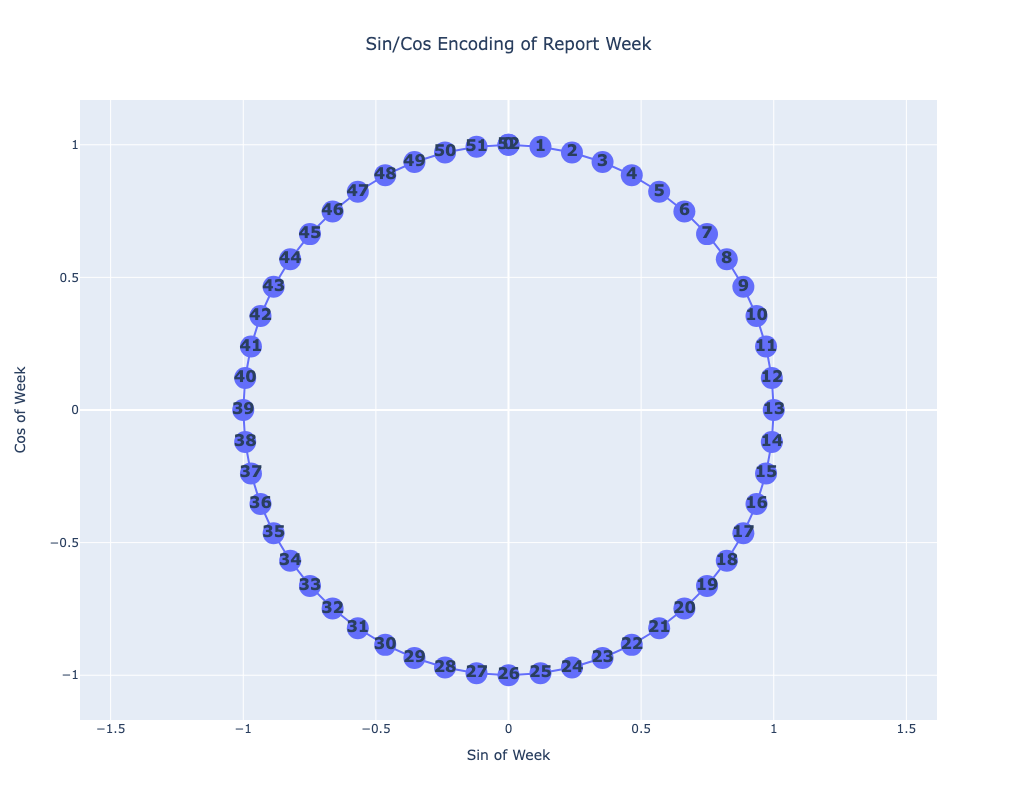

In [88]:
df_weekly_averages = add_column_cyclical_features(df_weekly_averages, 'report_week', 52, 1)

fig1 = go.Figure()
fig1.add_trace(go.Scatter(
     x=df_weekly_averages['sin_report_week'],
     y=df_weekly_averages['cos_report_week'],
     name='Sin vs Cos for Report Week',
     mode='lines+markers+text',
     text=["<b>" + str(i) + "</b>" for i in range(0,60)],
     showlegend=False
 ))
fig1.update_traces(textfont_size=16, marker=dict(size=22))
fig1.update_layout(hovermode="x", xaxis_title="Sin of Week", yaxis_title="Cos of Week", 
                   yaxis = dict(scaleanchor = "x", scaleratio = 1), width=800, height=800, 
                   legend=dict(orientation="h", x=0.05), title="Sin/Cos Encoding of Report Week", title_x=0.5)
fig1.show()

In [81]:
df_features = df_calls_pivot.merge(df_yearweek_total_calls, on='date', how='left')\
                            .merge(df_weekly_averages, on='report_week', how='left')\
                            .merge(df_weekly_total_calls_averages, on='report_week', how='left')\
                            .merge(df_numbered_months, on='date', how='left')

# df_features['report_week_total_calls_divergence'] = df_features['report_week_total_calls'] - df_features['report_week_mean_total_calls'] 

for col in [x for x in df_calls_pivot.columns if x.startswith('season')]:
    df_features[col + '_divergence'] = df_features[col] - df_features['report_week_mean_' + col]

drop_cols = [x for x in df_features.columns if x.startswith('report_week_mean')]  
df_features = df_features.drop(columns=drop_cols)
df_features = df_features.sort_values(['report_year', 'report_week'])

In [82]:
df_outcomes = df_prices[['date', 'price']]
df_outcomes = build_outcomes(df_outcomes, 'price', 'date', n_forward_looks = [30, 15, 7])

In [83]:
df_model = df_features.merge(df_outcomes, on='date', how='left')
df_model['report_month'] = pd.to_datetime(df_model['date']).dt.month

In [91]:
df_model.to_csv('../cotton/data/df_on_call_mset.csv', index=False)

In [84]:
season_vars = [x for x in df_model.columns if x.startswith('season')]
correlation_vars = [x for x in df_model.columns if x not in ['report_year', 'date', 'price'] + season_vars]
outcome_vars = [x for x in df_outcomes if x not in ['date', 'price']]
df_corr = df_model[correlation_vars].corr()
df_corr = df_corr.drop(outcome_vars, axis=0)[outcome_vars].sort_values('value_delta_mean_30_forward')
df_corr.style.background_gradient(cmap='coolwarm')

,value_delta_mean_30_forward,value_delta_max_30_forward,pct_delta_mean_30_forward,pct_delta_max_30_forward,mean_rise_30_forward,max_rise_30_forward,value_delta_mean_15_forward,value_delta_max_15_forward,pct_delta_mean_15_forward,pct_delta_max_15_forward,mean_rise_15_forward,max_rise_15_forward,value_delta_mean_7_forward,value_delta_max_7_forward,pct_delta_mean_7_forward,pct_delta_max_7_forward,mean_rise_7_forward,max_rise_7_forward
sin_report_week,-0.073205,-0.048303,-0.072890,-0.075658,-0.060659,-0.052888,-0.041141,-0.017463,-0.039590,-0.046636,-0.039107,-0.043626,-0.017102,0.009268,-0.016101,-0.014401,-0.033823,-0.053674
calls_month_6_away,-0.032770,-0.017471,-0.035415,-0.041260,0.010508,-0.026341,-0.027529,0.003016,-0.032558,-0.018722,0.033516,-0.027029,-0.015891,0.008340,-0.022442,-0.013683,-0.026226,-0.018350
calls_month_7_away,-0.025057,0.085963,-0.024943,0.038443,-0.009593,-0.005635,-0.038578,0.074307,-0.032676,0.029007,-0.006140,0.008116,-0.033413,0.070780,-0.025268,0.040739,0.005387,0.016123
calls_month_8_away,0.042314,0.138709,-0.045948,0.035658,-0.026739,-0.041752,0.047591,0.161062,-0.034413,0.068609,-0.005287,-0.073673,0.020026,0.138212,-0.052366,0.051607,-0.044381,-0.069596
calls_month_2_away,0.047220,0.186609,0.036829,0.084790,0.063046,0.115631,0.025617,0.185441,0.020422,0.082989,0.025375,0.106369,0.004258,0.186510,0.004344,0.098651,0.059186,0.112517
report_month,0.053389,0.027345,0.083334,0.067046,0.094166,0.056794,0.016461,-0.000800,0.042807,0.043481,0.056812,0.048849,0.001935,-0.018152,0.019079,0.018304,0.037901,0.060167
calls_month_1_away,0.054841,0.076832,0.033583,0.005768,0.005113,-0.037123,0.062666,0.080504,0.048714,0.016679,0.025672,-0.022965,0.061242,0.076425,0.053698,0.029888,0.005872,-0.013802
report_week,0.055955,0.029705,0.082755,0.069140,0.093333,0.063810,0.018002,-0.000973,0.040688,0.041764,0.055814,0.054255,0.002234,-0.019344,0.017374,0.014465,0.031808,0.061638
calls_month_4_away,0.056879,0.149520,0.065505,0.101506,0.038816,0.094955,0.042764,0.159114,0.053205,0.109018,0.070018,0.081639,0.035061,0.144768,0.043895,0.101846,0.035015,0.093547
calls_month_3_away,0.117595,0.230324,0.088285,0.136083,0.043616,0.006626,0.077654,0.190912,0.057258,0.104683,0.055605,0.013172,0.043661,0.145449,0.028465,0.065251,0.024903,0.009020


In [85]:
correlations = []
for month in df_model['report_month'].unique():
    df = df_model[df_model['report_month'] == month]
    df_corr = df[correlation_vars].corr()
    df_corr = df_corr.drop(outcome_vars, axis=0)[outcome_vars].sort_values('value_delta_mean_30_forward')
    df_corr['month'] = month
    correlations.append(df_corr)

In [76]:
correlations[0]

,value_delta_mean_30_forward,value_delta_max_30_forward,pct_delta_mean_30_forward,pct_delta_max_30_forward,mean_rise_30_forward,max_rise_30_forward,value_delta_mean_15_forward,value_delta_max_15_forward,pct_delta_mean_15_forward,pct_delta_max_15_forward,mean_rise_15_forward,max_rise_15_forward,value_delta_mean_7_forward,value_delta_max_7_forward,pct_delta_mean_7_forward,pct_delta_max_7_forward,mean_rise_7_forward,max_rise_7_forward,month
calls_month_6_away,-0.080921,-0.030978,-0.141920,-0.077116,0.026534,-0.074408,-0.058247,-0.014731,-0.102911,-0.046919,-0.073253,-0.074994,-0.056882,-0.035704,-0.111306,-0.072348,-0.163239,-0.173490,2
report_week,-0.015728,-0.038720,0.015437,0.039751,0.126288,0.165375,0.058842,0.037791,0.092790,0.144650,0.161352,0.085384,0.106650,0.087083,0.163587,0.219152,0.141458,0.214707,2
calls_month_1_away,-0.012456,0.067707,-0.013308,0.041044,-0.093453,-0.076924,-0.060672,-0.000688,-0.069843,-0.055633,-0.108097,-0.064266,-0.061376,-0.054347,-0.109907,-0.145806,-0.162189,-0.196430,2
calls_month_8_away,-0.012077,0.263381,-0.211672,0.069441,-0.111563,-0.089962,0.090964,0.299695,-0.059756,0.140673,-0.125698,-0.074440,0.071656,0.276012,-0.011257,0.175174,-0.134472,-0.047150,2
sin_report_week,-0.009644,-0.037600,0.024958,0.042840,0.138175,0.168495,0.061523,0.035702,0.098829,0.143738,0.167294,0.093878,0.101824,0.082245,0.158013,0.210036,0.149460,0.223815,2
cos_report_week,0.022245,0.039895,-0.004048,-0.034642,-0.111444,-0.160252,-0.055768,-0.040148,-0.084848,-0.143823,-0.151275,-0.073895,-0.111539,-0.092021,-0.167980,-0.226890,-0.131064,-0.201229,2
calls_month_7_away,0.038297,0.147116,-0.081592,-0.024818,0.003379,-0.046384,0.049990,0.157774,-0.038287,0.022222,-0.074126,-0.054941,0.024317,0.154990,-0.032287,0.062605,-0.133901,-0.122339,2
calls_month_4_away,0.081053,-0.034933,0.159046,0.109015,0.151751,0.071175,0.117556,0.031923,0.212378,0.184999,0.210203,0.153088,0.087058,0.000961,0.195611,0.124843,0.104950,0.239488,2
calls_month_2_away,0.104683,0.252082,0.088601,0.144863,0.161596,0.104160,0.037133,0.138888,0.047191,0.067827,-0.024170,0.096714,0.010549,0.116802,0.021087,0.073448,0.042467,-0.062945,2
calls_month_5_away,0.118187,0.342576,0.091358,0.294763,0.141986,0.080163,0.060862,0.213107,0.062633,0.185542,-0.033899,0.023909,0.029918,0.158481,0.034173,0.145984,-0.004318,-0.070971,2


<Axes: xlabel='calls_month_3_away', ylabel='value_delta_max_30_forward'>

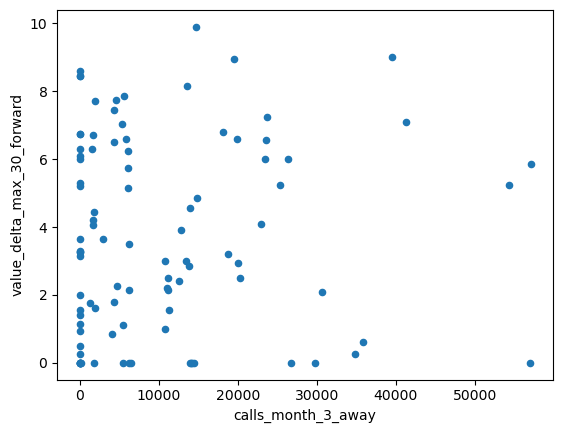

In [80]:
df_model[df_model.report_month==5].plot(x='calls_month_3_away', y='value_delta_max_30_forward', kind='scatter')

/Users/thomaspile/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



<Axes: xlabel='calls_month_6', ylabel='pct_delta_mean_30_forward'>

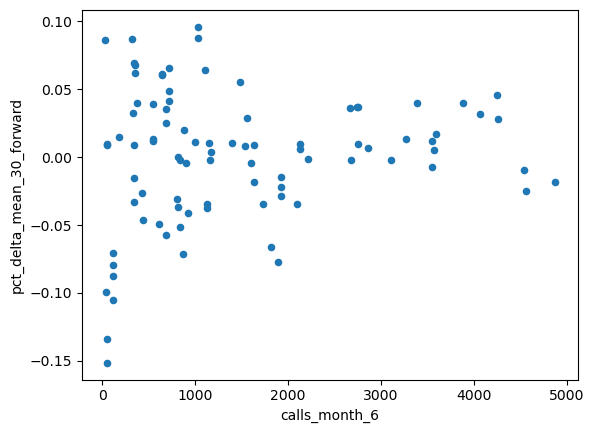

In [53]:
df_model[df_model.report_month==6].plot(x='calls_month_6', y='pct_delta_mean_30_forward', kind='scatter')

/Users/thomaspile/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



<Axes: xlabel='season1_05', ylabel='pct_delta_mean_30_forward'>

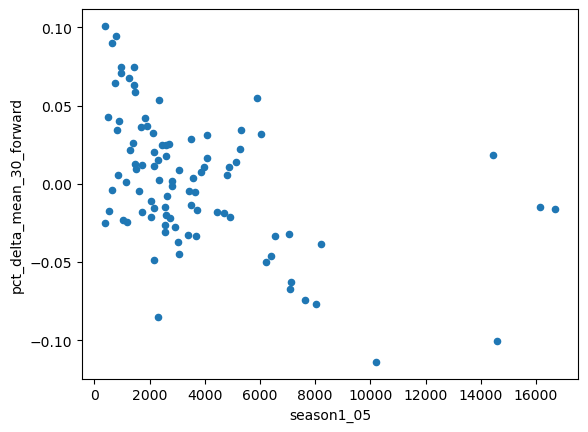

In [54]:
df_model[df_model.report_month==2].plot(x='season1_05', y='pct_delta_mean_30_forward', kind='scatter')

<Axes: xlabel='calls_month_3_away', ylabel='pct_delta_mean_30_forward'>

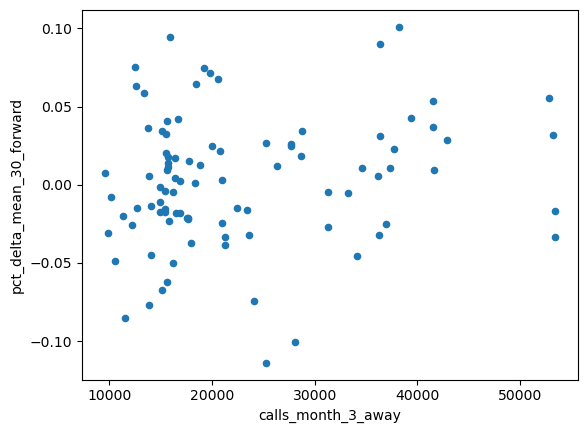

In [72]:
df_model[df_model.report_month==2].plot(x='calls_month_3_away', y='pct_delta_mean_30_forward', kind='scatter')

<Axes: xlabel='season1_05_divergence', ylabel='pct_delta_mean_30_forward'>

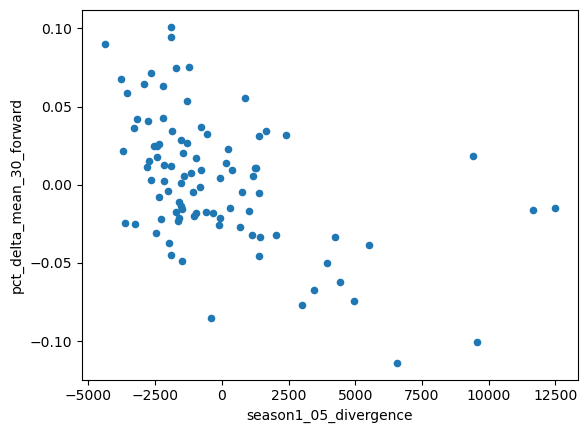

In [55]:
df_model[df_model.report_month==2].plot(x='season1_05_divergence', y='pct_delta_mean_30_forward', kind='scatter')

In [56]:
df_2 = df_model[df_model.report_month==2][['report_year','report_week', 'season1_05', 'season1_05_divergence', 'pct_delta_mean_30_forward']]

/Users/thomaspile/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



<Axes: xlabel='season1_05', ylabel='season1_05_divergence'>

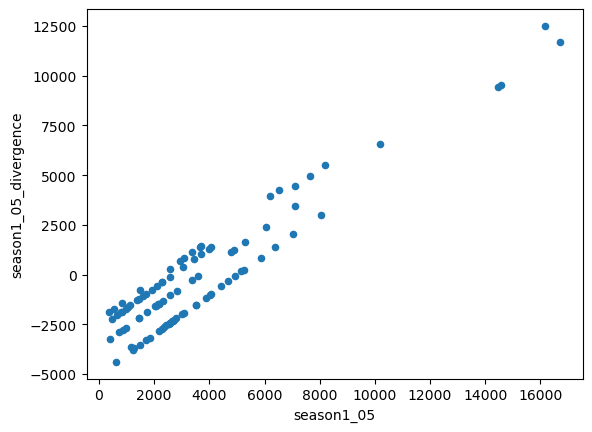

In [57]:
df_2.plot(x='season1_05', y='season1_05_divergence', kind='scatter')

/Users/thomaspile/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



<Axes: xlabel='season1_03_divergence', ylabel='value_delta_mean_30_forward'>

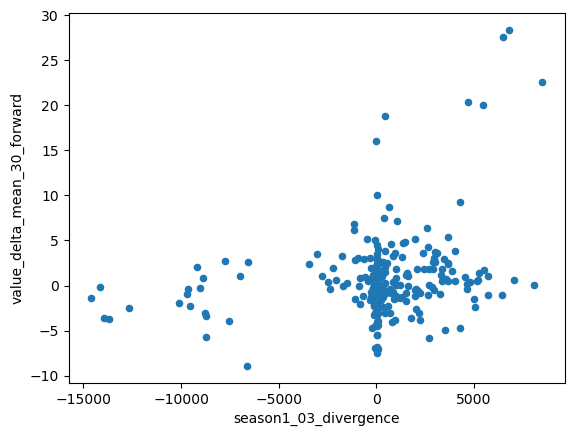

In [20]:
df_model.plot(x='season1_03_divergence', y='value_delta_mean_30_forward', kind='scatter')

In [ ]:
df_model.plot(x='season1_03_divergence', y='value_delta_mean_30_forward', kind='scatter')

<Axes: xlabel='cos_report_week', ylabel='value_delta_mean_30_forward'>

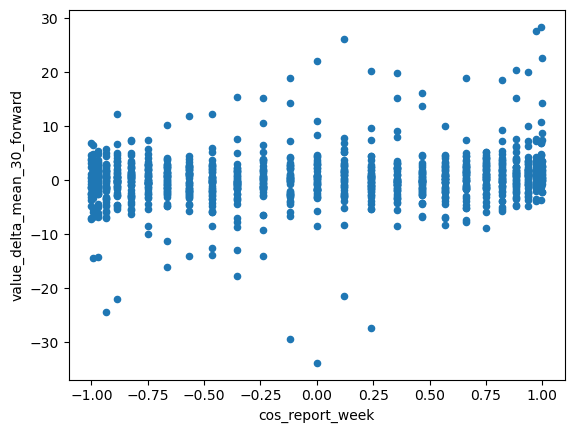

In [32]:
df_model.plot(x='cos_report_week', y='value_delta_mean_30_forward', kind='scatter')

<Axes: xlabel='cos_report_week', ylabel='mean_30_forward'>

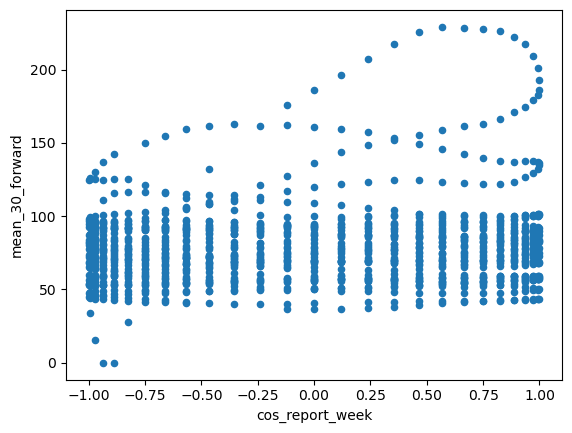

In [19]:
df_model.plot(x='cos_report_week', y='mean_30_forward', kind='scatter')

/Users/thomaspile/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



<Axes: xlabel='report_week_total_calls', ylabel='delta_mean_30_forward'>

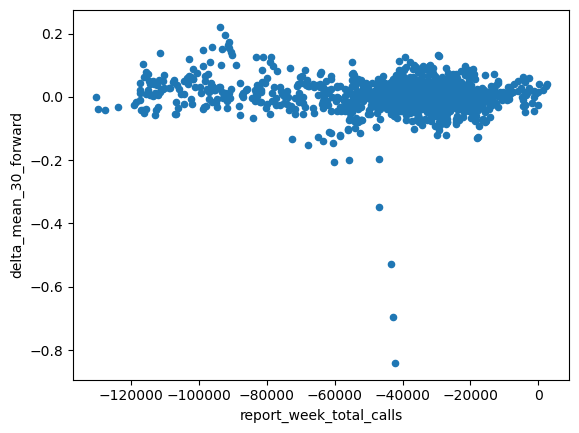

In [19]:
df_model.plot(x='report_week_total_calls', y='delta_mean_30_forward', kind='scatter')

In [15]:
years = [2020, 2021, 2022, 2023]
df_recent = df_yearweek_total_calls[df_yearweek_total_calls.report_year.isin(years)]
df_recent

,date,report_year,report_week,report_week_total_calls
984,2020-01-09,2020,1,-54237
985,2020-01-16,2020,2,-56006
986,2020-01-23,2020,3,-57034
987,2020-01-30,2020,4,-54876
988,2020-02-06,2020,5,-52332
...,...,...,...,...
1187,2023-12-01,2023,48,-9890
1188,2023-12-08,2023,49,-11409
1189,2023-12-15,2023,50,-11225
1190,2023-12-22,2023,51,-5420


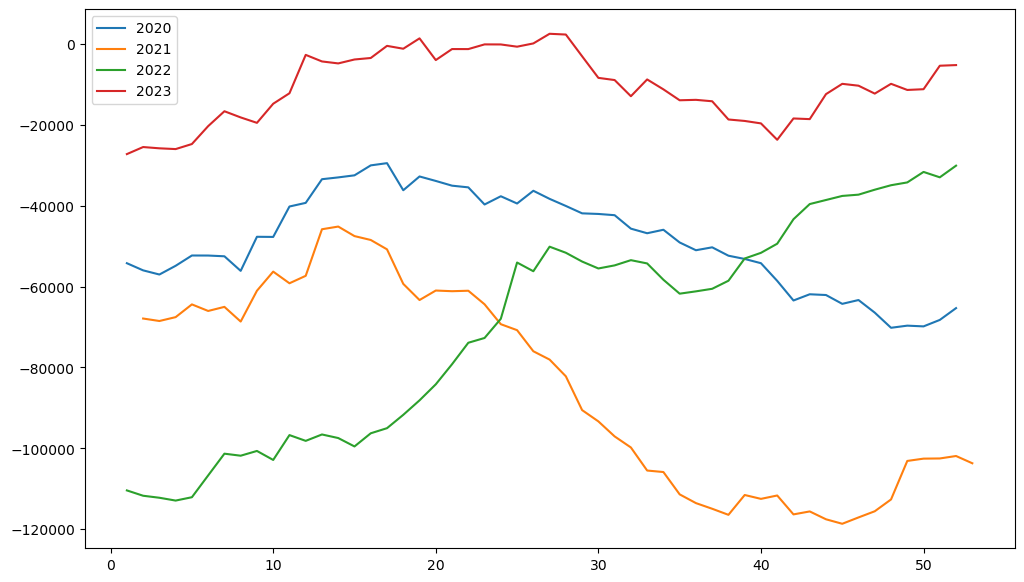

In [18]:
_, ax = plt.subplots(figsize=(12, 7))

for year in years:
    df = df_yearweek_total_calls[df_yearweek_total_calls.report_year == year]
    ax.plot(df['report_week'], df['report_week_total_calls'], label=year)
ax.legend()

In [ ]:
df_calls.pivot_table(index='report_week', columns='futures_month', values='unfixed_sale')

In [ ]:
pd.to_datetime(df_calls['month']).dt.isocalendar()

In [ ]:
df_calls.groupby('date').month.count().reset_index().sort_values('date')

In [ ]:
df_calls[df_calls.date=='2024-06-07']

In [ ]:
df_calls.groupby('date').month.nunique().reset_index().sort_values('date')

In [ ]:
df_calls.groupby(['report_week', 'month']).unfixed_sale.mean()